<a href="https://colab.research.google.com/github/Lucas01iveira/Projeto-SuperNovas-IA/blob/master/AtividadesSNIa_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dúvidas - (Aula de segunda)

- Sobre a estimativa dos parâmetros pela força bruta: qual precisão utilizar (quantidade N de pontos)?

<p>&nbsp;</p>

- Sobre o cálculo do ângulo $\theta$ de inclinação da elipse de confiança: 

$$ \tan(2\theta) = \frac{2\sigma_{xy}}{\sigma_x^2 - \sigma_y^2}  $$

é correto acrescentar um módulo no denominador para corrigir casos em que $\sigma_{xy} < 0$ e $\sigma_{x} < \sigma_y$? (sem o módulo aparece um sinal de "-" no denominador de modo que o $\theta$, ao invés de colocar a elipse com inclinação para baixo, coloca com inclinação para cima).  

<p>&nbsp;</p>

- Sobre a tarefa (d): como apresentar os diferentes intervalos de confiança? Se graficamente através de um gráfico $\Omega_{m,0} x \Omega_{EE,0}$, como podemos obter a covariância entre esses dois parâmetros? (no código implementado para essa tarefa, o resultado obtido são as covariâncias entre $\Omega_{m,0}$ e $\Omega_{EE,0}$ e $w$ apenas).

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad as Int
import numpy as np 
import pandas as pd

### Funções e códigos auxiliares

- Função dL 
- Função mu

In [ ]:
# Parâmetros de entrada
  # - H0: Constante de Hubble (km * s^-1 * Mpc^-1)
  # - Omega_m0: parâmetro de densidade da matéria no instante atual (adimensional)
  # - Omega_EE0: parâmetro de densidade da energia escura no instante atual (adimensional)
  # - w: parâmetro da equação de estado associado à energia escura (adimensional)
  # - z: redshift da luz observada

# Valores de saída
  # Distância de luminosidade em Mpc
  # Estimativa do erro no cálculo de dL (associado aos procedimentos numéricos)

def dL(H0, Omega_m0, Omega_EE0, w, z):
  import numpy as np
  from scipy.integrate import quad as Int

# ______________________________________________________________________________
  # 1) Constantes fundamentais
  c = 3*(10**8) # velocidade da luz
  H0_s = H0/(3.086*(10**19)) # constante de Hubble convertida para s^(-1)
  DH = (c/H0_s)*(3.24*(10**(-23))) # distância de Hubble convertida para Mpc

# ______________________________________________________________________________
  # 2) Definição da função 1/E(z)
  # (Os parâmetros de entrada já foram descritos anteriormente)
  def inv_E(z, Omega_m0, Omega_EE0, w):
    Omega_k0 = 1 - (Omega_m0 + Omega_EE0)
    return 1/(np.sqrt( Omega_m0*(1+z)**3 + Omega_EE0*(1+z)**(3*(1+w)) + Omega_k0*(1+z)**2 ))

# ______________________________________________________________________________
  # 3) Definição do script de integração da função 1/E via método de "quadratura Gaussiana"
  # (usando a função do scipy) entre os limites de integração 0 a z

  # Parâmetros de entrada
    # - Parâmetros cosmológicos (já descritos)
    # - z (redhisft): limite superior da integração

  # Valores de saída
    # - A estimativa numérica da integral 
    # - A estimativa do erro associado ao cálculo numérico dessa integral

  def integra_inv_E(Omega_m0, Omega_EE0, w, z):
      resultado_aproximado, erro_aproximado = Int(inv_E, 0, z, args=(Omega_m0, Omega_EE0, w))
      return resultado_aproximado, erro_aproximado

# ______________________________________________________________________________
  # 4) Definição da função que calcula a distância comóvel DC

  # Parâmetros de entrada
    # - Parâmetros cosmológicos (já descritos)
    # - z(redshift)

  # Valores de saída:
    # - A estimativa da distância comóvel DC em Mpc
    # - A estimativa do erro associado ao cálculo dessa distância comóvel em Mpc
  
  def DC(Omega_m0, Omega_EE0, w, z):
    valor_integral, erro_valor_integral = integra_inv_E(Omega_m0, Omega_EE0, w, z)

    dist_comov = DH*valor_integral
    erro_dist_comov = DH*erro_valor_integral

    return dist_comov, erro_dist_comov

# ______________________________________________________________________________
  # 5) Definição da função que calcula a distância de movimento próprio DM

  # Parâmetros de entrada
    # - Parâmetros cosmológicos (já descritos)
    # z (redshift)

  # Valores de saída
    # DM (em Mpc) de acordo com as condições em Omega_k0 (parâmetro de curvatura)
  
  def DM(Omega_m0, Omega_EE0, w, z):
    Omega_k0 = 1 - (Omega_m0 + Omega_EE0)
    dist_comov, erro_dist_comov = DC(Omega_m0, Omega_EE0, w, z)

    if Omega_k0 > 0:
      dist_mov_prop = DH*( 1/np.sqrt(Omega_k0) )*np.sinh( np.sqrt(Omega_k0)*(dist_comov/DH) ) 
      erro_dist_mov_prop = DH*( 1/(np.sqrt(Omega_k0)) )*np.cosh( np.sqrt(Omega_k0)*(dist_comov/DH) )*( np.sqrt(Omega_k0)/DH )*erro_dist_comov 

      return dist_mov_prop, erro_dist_mov_prop

    elif Omega_k0 == 0:
      return dist_comov, erro_dist_comov

    elif Omega_k0 < 0:
        dist_mov_prop = DH*( 1/np.sqrt(np.abs(Omega_k0)) )*np.sin( np.sqrt(np.abs(Omega_k0))*(dist_comov/DH) ) 
        erro_dist_mov_prop = DH*( 1/np.sqrt(np.abs(Omega_k0)) )*np.cos( np.sqrt(np.abs(Omega_k0))*(dist_comov/DH) )*\
                                 ( np.sqrt(np.abs(Omega_k0))/DH )*erro_dist_comov                   
        return dist_mov_prop, erro_dist_mov_prop

# ______________________________________________________________________________
  # 6) Retorno o valor da distância de luminosidade dL, em Mpc, e seu respectivo erro (aleatório),
  # também em Mpc, associado aos métodos de cálculo numérico empregados.

  DM, erro_DM = DM(Omega_m0, Omega_EE0, w, z)

  dist_luminosidade = DM*(1+z)
  erro_dist_luminosidade = erro_DM*(1+z)

  return dist_luminosidade, erro_dist_luminosidade

In [ ]:
# Parâmetros de entrada (são os mesmos da função dL)
  # - H0: Constante de Hubble (km s^-1 Mpc^-1)
  # - Omega_m0: parâmetro de densidade da matéria no instante atual (adimensional)
  # - Omega_EE0: parâmetro de densidade da energia escura (adimensional)
  # - w: parâmetro da equação de estado associado à energia escura (adimensional)
  # - z: redshift de observação

# Valores de saída:
  # - Estimativa do módulo de distância
  # - Estimativa do erro associado ao módulo de distância calculado 
  # (o erro dos cálculos numéricos)

def mu_numerico(H0, Omega_m0, Omega_EE0, w, z):
  import numpy as np
  dist_luminosidade, erro_dist_luminosidade = dL(H0, Omega_m0, Omega_EE0, w, z)

  mod_dist = 5*np.log10(dist_luminosidade) + 25 # distância de luminosidade já fornecida em Mpc
  erro_mod_dist = 5*erro_dist_luminosidade/(dist_luminosidade*np.log(10)) # distância de luminosidade já fornecida em Mpc
  return mod_dist, erro_mod_dist

## Início da atividade 2

In [ ]:
# Leio os dados e defino o dataframe de trabalho

df = pd.read_csv('SN_2022.txt', sep=' ')

z_i = df['z'].to_numpy()
mu_i = df['mu'].to_numpy()
erro_mu_i = df['erro_mu'].to_numpy()

df.head()

,z,mu,erro_mu
0,0.028488,35.339320,0.223906
1,0.050043,36.669580,0.166829
2,0.052926,36.804163,0.155756
3,0.070086,37.428796,0.158467
4,0.062668,37.467377,0.156099


### Tarefa 0 

- Construir um código de determinação dos melhores parâmetros $\Omega_{m,0}$ e $\Omega_{EE,0}$ que melhor
ajustam os dados fornecidos de acordo com o modelo de universo em estudo.

In [ ]:
# Construo uma função para ajustar os valores de Omega_m0 e Omega_EE0 que melhor se encaixam
# aos dados observados supondo w = -1 (energia escura do tipo const cosmológica)

# Parâmetros de entrada:
  # - z: Vetor com os valores observados de redshift
  # - mu: Vetor com os valores medidos de módulo de distância
  # - erro_mu: Vetor com os valores de erro (incerteza) dos módulos de distância medidos
  # - start_omegas: valor inicial de Omega_m0 e Omega_EE0
  # - end_omegas: valor final de Omega_m0 e Omega_EE0
  # - N: quantidade de pontos desejados dentro do intervalo [start_omegas, end_omegas]
  # - w: parâmetro da equação de estado associado à energia escura
  # - param_curv: parâmetro indicativo de curvatura

# Obs.: param_curv é uma variável auxiliar que utilizaremos; deverá receber valor 0 
# se o modelo de universo em utilização apresentar curvatura plana e valor -1
# se a curvatura do universo em estudo for desconhecida (caso genérico)

# Valores de saída:
  # - Omega_m0_best_fit: valor de Omega_m0 que melhor se ajusta aos dados (considerando o modelo de universo)
  # - Omega_EE0_best_fit: valor de Omega_EE0 que melhor se ajusta aos dados (considerando o modelo de universo)
  # - chi2_min: valor da soma quadrática dos resíduos para Omega_m0_best_fit e Omega_EE0_best_fit
  # - chi2: matriz de resíduos quadráticos associada aos parâmetros "omega" utilizados (i.e., matriz de "chi2's")
  # - cov: matriz de covariância do ajuste

def ajusta_dados(z, mu, erro_mu, start_omegas, end_omegas, N, w, param_curv):
  import numpy as np 

  # Quantidades auxiliares
  zsize = len(z)
  H0 = 70 # km s^-1 Mpc^-1

  # __________________________________________________________________
  # 1) Construção dos parâmetros Omega_m0 e Omega_EE0
  if param_curv == 0: # Caso do universo de curvatura plana (Omega_m e Omega_EE conectados)
    Omega_m0 = np.linspace(start_omegas, end_omegas, N)
    Omega_EE0 = 1 - Omega_m0

  else: # Caso genérico de universo com curvatura desconhecida
    Omega_m0 = np.linspace(start_omegas, end_omegas, N)
    Omega_EE0 = np.linspace(start_omegas, end_omegas, N)
  
  # Quantidades auxiliares
  Om_size = len(Omega_m0)
  OEE_size = len(Omega_EE0)

  # __________________________________________________________________
  # 2) Construção da grade de parâmetros (Omega_m0 x Omega_EE0)

  M = [] # Matriz da grade de parâmetros

  # Cada elemento da matriz M representa um vetor com um par de parâmetros, ou seja
  # M[i][j] == [ Omega_m0[i], Omega_EE0[j] ]
  
  for i in range(Om_size):
    auxiliar1 = [] # Vetor que compõe a linha (i) de M

    for j in range(OEE_size): 
      auxiliar2 = [Omega_m0[i], Omega_EE0[j]] # Vetor auxiliar que compõe a coluna (j) de M
      auxiliar1.append(auxiliar2)

    M.append(auxiliar1) # Coloco a linha i dentro da matriz

  M = np.array(M) # Grade de parâmetros finalizada

  # __________________________________________________________________
  # 3) Calculo a matriz de Q, o chi2 e os melhores parâmetros do ajuste

  chi2= np.zeros( (Om_size, OEE_size) )
  chi2_min = 100000 # defino o chi2 inicialmente com um valor absurdo só pra dar início ao loop corretamente
  Omega_m0_best_fit = 0
  Omega_EE0_best_fit = 0

  for i in range(Om_size):
    for j in range(OEE_size):
      # Aqui dentro eu tenho acesso ao vetor [Omega_m0[i], Omega_EE0[j]] de M
      
      Omega_m0i = M[i][j][0]
      Omega_EE0j = M[i][j][1]

      # Faço um novo loop para construir a matriz Q de resíduos e obter
      # as quantiades desejadas

      soma = 0 # variável auxiliar para calcular a soma dos resíduos quadráticos
      for k in range(zsize):
        mod_dist, erro_mod_dist = mu_numerico(H0, Omega_m0i, Omega_EE0j, w, z[k])
        soma += ( ( mu[k] - mod_dist )/erro_mu[k] )**2

      # Atualizo a matriz chi2 e verifico as condições de ajuste
      chi2[i][j] = soma

      if param_curv == 0: # se eu estiver num modelo de curvatura plana
        if soma < chi2_min and i==j: # preciso verificar se a soma de resíduos é mínima *E* se eu estou na diagonal principal de M

        # (por que é na diagonal principal de M que estão armazenados os parâmetros associados ao modelo de universo plano)

          chi2_min = soma
          Omega_m0_best_fit = Omega_m0i
          Omega_EE0_best_fit = Omega_EE0j

          # Para facilitar o cálculo da matriz de Fisher, guardo os índices 
          # que forneceram os valores do ajuste
          i_min = i
          j_min = j

         
      else: # se eu estiver num modelo de curvatura genérica
        if soma < chi2_min: # preciso verificar somente se a soma de resíduos é mínima
          chi2_min = soma
          Omega_m0_best_fit = Omega_m0i
          Omega_EE0_best_fit = Omega_EE0j

          # Para facilitar o cálculo da matriz de Fisher, guardo os índices 
          # que forneceram os valores do ajuste
          i_min = i
          j_min = j

  # __________________________________________________________________
  # 4) Obtenção da matriz de Fisher

  # Defino uma quantidade auxiliar: delta_omega (igual para ambos os omegas, por construção dos vetores)
  delta_omega = np.abs(end_omegas - start_omegas)/N

  # Elemento 00 da matriz de Fisher (2 derivada de chi2_min em 'x' = Omega_m)
  F_00 = (1/2)*( chi2[i_min+1,j_min] - 2*chi2[i_min,j_min] + chi2[i_min-1,j_min] )*(1/delta_omega)**2

  # Elemento 11 da matriz de Fisher (2 derivada de chi2_min em 'y' = Omega_EE)
  F_11 = (1/2)*( chi2[i_min,j_min+1] - 2*chi2[i_min,j_min] + chi2[i_min,j_min-1] )*(1/delta_omega)**2

  # Elementos 01/10 da matriz de Fisher 
  F_12_21 = (1/2)*( chi2[i_min+1, j_min+1] - chi2[i_min-1, j_min+1] - chi2[i_min+1, j_min-1] + chi2[i_min-1, j_min-1] )*(1/(4*delta_omega**2))

  F = np.array([ 
    [F_00, F_12_21],
    [F_12_21, F_11]
  ])

  # __________________________________________________________________
  # 5) Obtenção da matriz de covariância
  # Uma vez calculada a matriz de Fisher, a matriz covariância é simplesmente a inversa

  cov = np.linalg.inv(F)

  return Omega_m0_best_fit, Omega_EE0_best_fit, chi2, chi2_min, cov

### Tarefa (a)

Calcule o melhor valor (máxima verossimilhança) e os intervalos de 68,3%, 95,4 % e 99,7% (1, 2, 3 “σ” de uma distribuição Normal) para o ΩEE , supondo $w=-1$ e um Universo Plano.  Além disso, sabendo sobre a  probabilidade que P($Ω_{EE}$) ∝ exp(-𝜒2), calcule a probabilidade desses dados indicarem que a densidade da energia escura é maior do que 0.5 :

$$ \frac{\int_{0.5}^{+\infty} P(\Omega_{EE}) \, d\Omega_{EE}}{ \int_{-\infty}^{+\infty} P(\Omega_{EE}) \, d\Omega_{EE} }$$

Em problemas unidimensionais, com este,  Δχ = 1.0, 4.0, 9.0 para (1, 2, 3 “σ”).

Resolvo essa tarefa utilizando o método da força bruta

In [ ]:
# Defino uma funçãozinha auxiliar útil
# para apresentar os resultados de um ajuste de 2 parâmetros

# Parâmetros de entrada:
  # - param_fit1: parâmetro 1 obtido do ajuste (Omega_m0)
  # - param_fit2: parâmetro 2 obtido do ajuste (Omega_EE0)
  # - M_cov: matriz de covariância associada a esses parâmetros
  # - Q_min: chi2 (mínimo) do ajuste

# Valores de saída:
  # - Layout simples de apresentação

def apresenta_resultados(param_fit1, param_fit2, M_cov, Q_min):
  print('Parâmetros do ajuste obtidos pelo método da força bruta')

  print()
  print('Omega_m0 = {:.3f}'.format(param_fit1))
  print('Omega_EE0 = {:.3f}'.format(param_fit2))
  print('chi2 (Q mínimo)= {:.3f}'.format(Q_min))

  print()
  print('Matriz de covariância: ')
  for i in M_cov:
    print(i)

In [ ]:
Omega_m0_best_fit, Omega_EE0_best_fit,\
chi2, chi2_min, cov = ajusta_dados(z_i, mu_i, erro_mu_i, 0, 1, 100, -1, 0)

apresenta_resultados(Omega_m0_best_fit, Omega_EE0_best_fit, cov, chi2_min)

Parâmetros do ajuste obtidos pelo método da força bruta

Omega_m0 = 0.455
Omega_EE0 = 0.545
chi2 (Q mínimo)= 562.582

Matriz de covariância: 
[ 0.00568993 -0.00667472]
[-0.00667472  0.0090735 ]


In [ ]:
'{:.3f}'.format(3*np.sqrt(0.0090735))

'0.286'

In [ ]:
# Cálculo de probabilidade solicitado P(Omega_EE0 > 0.5) // Modelo de universo plano

sigma_Omega_m0_best_fit = np.sqrt(cov[0][0]) 
sigma_Omega_EE0_best_fit = np.sqrt(cov[1][1])
sigma_misto = cov[0][1]
corr = sigma_misto/(sigma_Omega_m0_best_fit*sigma_Omega_EE0_best_fit)


# Defino uma função que calcula a densidade de probabilidade associada ao parâmetro Omega_EE0 = y
# tal como definido no artigo de Coe (e já considerando Omega_m0 = x fixo em x0 = Omega_m0_best_fit)
# Parâmetros de entrada:
  # - y: variável y na qual a função será calculada
  # - y0: valor de referência ('verdadeiro') associado à variável y
  # - sigma_y: incerteza (estimativa do erro) das variáveis y
  # - rho: correlação entre a variável y e a variável x (fixa)

# Valores de saída:
  # - valor da função a cada ponto

def dens_prob(y, y0, sigma_y, rho):
  delta_y = y-y0
  var_chi2 = (delta_y/sigma_y)**2/(1-rho**2)
  return np.exp(-var_chi2/2)

# De fato, para estimar os parâmetros de melhor ajuste utilizamos um grid discreto de pontos. Para fazer
# a integral agora, entretanto, será suposto que estejamos tratando variáveis contínuas.
# Apesar de ser incoerente, o grid discreto de pontos apresentou espaçamentos tão pequenos
# que é razoável supor a continuidade agora para poder realizar a integral.

num, err_num = Int(dens_prob, 0.5, 1, args=(Omega_EE0_best_fit, sigma_Omega_EE0_best_fit, corr))
den, err_den = Int(dens_prob, 0, 1, args=(Omega_EE0_best_fit, sigma_Omega_EE0_best_fit, corr))

# A integral do numerador representa a integral da dens_prob de 0.5 até 1 (i.e., de 0.5 até o valor máximo possível de
# Omega_EE0 == y, pois queremos saber a prob de Omega_EE0 = y ser maior q 0.5)

# A integral do denominador é simplesmente a integral da dens_prob entre todos os valores possíveis de Omega_EE0 = y
# (normalização do resultado; pq a princípio a função dens_prob pode não estar normalizada). Como o grid total de valores
# utilizados para Omega_EE0 foi [0,1], então esse deve ser o intervalo de integração.
prob = num/den

print('Probabilidade de que Omega_EE0 seja maior do que 0.5')
print('P(Omega_EE0 > 0.5) = {:.4f}'.format(prob))


Probabilidade de que Omega_EE0 seja maior do que 0.5
P(Omega_EE0 > 0.5) = 0.9013


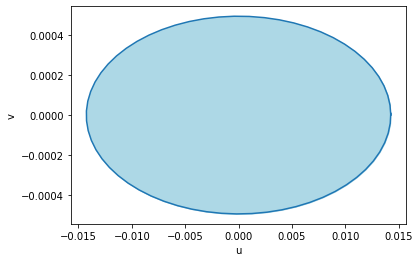

In [ ]:
# Apresentação da elipse de confiança (script teste)
sigma_Omega_m0_best_fit = np.sqrt(cov[0][0])
sigma_Omega_EE0_best_fit = np.sqrt(cov[1][1])
sigma_misto = cov[0][1]

a_0 = (sigma_Omega_m0_best_fit**2 + sigma_Omega_EE0_best_fit**2)/2 \
+ np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)**2 + sigma_misto**2)

b_0 = (sigma_Omega_m0_best_fit**2 + sigma_Omega_EE0_best_fit**2)/2 \
- np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)**2 + sigma_misto**2)

#theta = (1/2)*np.arctan( (2*sigma_misto)/(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2) )
theta = (1/2)*np.arctan( (2*sigma_misto)/np.abs((sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)) )

# Acrescentei um np.abs() na divisão para lidar com os casos em que sigma_x**2 < sigma_y**2
# (pq nessas situações apareceria um sinal de - que mudaria a inclinação da elipse *incorretamente*)

# Monto as equações parâmetricas no espaço uv para o qual a elipse está 'reta'
# apenas para verificar se o código está funcionando corretamente
def u(t,a):
  return a*np.cos(t)

def v(t, b):
  return b*np.sin(t)

t_plot = np.arange(0,2*np.pi+0.1, 0.1)
plt.plot(u(t_plot,a_0), v(t_plot, b_0))
plt.ylabel('v')
plt.xlabel('u')
plt.fill_between(
    x = u(t_plot, a_0),
    y1 = v(t_plot, b_0),
    where = (0 < t_plot) & (t_plot < 2*np.pi),
    color='lightblue'
)
plt.show()

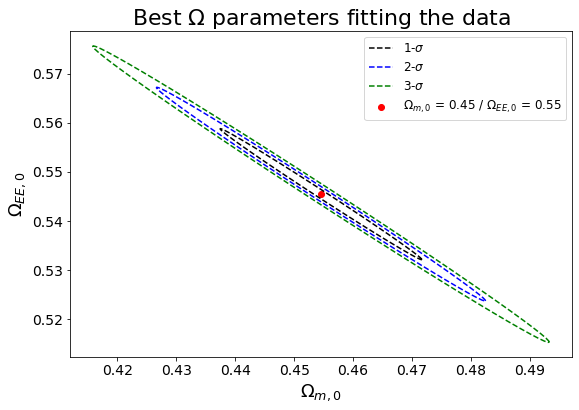

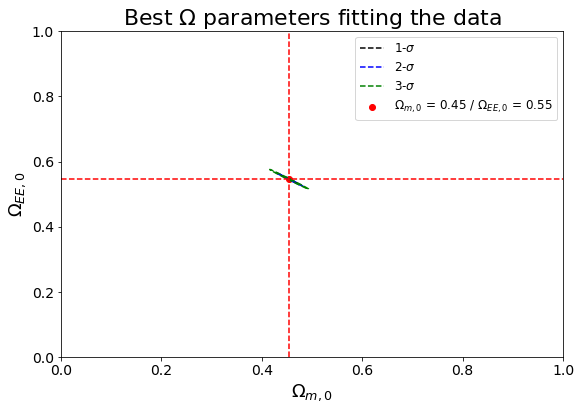

In [ ]:
# Monto as equações paramétricas da elipse rotacionada/transladada no espaço Omega_m0 x Omega_EE0

def Omega_m0_elipse(t, a, b):
  return Omega_m0_best_fit+(a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta))

def Omega_EE0_elipse(t, a, b):
  return Omega_EE0_best_fit+(a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta))

t_plot = np.arange(0, 2*np.pi+0.1, 0.1)

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + '$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit)
ax = plt.scatter(Omega_m0_best_fit, Omega_EE0_best_fit, color='red', label=legenda)
# Ponto (Omega_m0_best_fit, Omega_EE0_best_fit)

# Defino os parâmetros da elipse para cada intervalo de confiança

alpha = [1.52, 2.48, 3.44] # vetor de fatores multiplicativos alpha
# O elemento 0 representa o alpha associado à elipse 1-sigma
# O elemento 1 representa o alpha associado à elipse 2-sigma
# O elemento 2 representa o alpha associado à elipse 3-sigma

a_1s = a_0*alpha[0]
b_1s = b_0*alpha[0]

a_2s = a_0*alpha[1]
b_2s = b_0*alpha[1]

a_3s = a_0*alpha[2]
b_3s = b_0*alpha[2]

# Faço os plots
# 1-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ parameters fitting the data', fontsize=22)
plt.xlabel('$\Omega_{m,0}$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.49,0.52)
#plt.ylim(0.58,0.62)
plt.legend(fontsize=12)
plt.show()
print()

# _____________________________________________________________________________________

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + '$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit)
ax = plt.scatter(Omega_m0_best_fit, Omega_EE0_best_fit, color='red', label=legenda)

# Faço os plots
# 1-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ parameters fitting the data', fontsize=22)
plt.xlabel('$\Omega_{m,0}$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.50,0.51)
#plt.ylim(0.59,0.61)
plt.xlim(0,1)
plt.ylim(0,1)

# Plot de linhas horizontais e verticais para facilitar a visualização do ponto
ax = plt.axhline(y=Omega_EE0_best_fit, color='red', linestyle='dashed')
ax = plt.axvline(x=Omega_m0_best_fit, color='red', linestyle='dashed')

plt.legend(fontsize=12)
plt.show()

### Tarefa (b)

Calcule o melhor valor (máxima verossimilhança) e as os intervalos de 68,3%, 95,4 % e 99,7% (1, 2, 3 “σ” de uma distribuição Normal) para $Ω_{m}$ e $Ω_{EE}$ , supondo $w=-1$.

In [ ]:
Omega_m0_best_fit, Omega_EE0_best_fit, chi2, chi2_min,\
 cov = ajusta_dados(z_i, mu_i, erro_mu_i, 0, 1, 100, -1, -1)

apresenta_resultados(Omega_m0_best_fit, Omega_EE0_best_fit, cov, chi2_min)

Parâmetros do ajuste obtidos pelo método da força bruta

Omega_m0 = 0.495
Omega_EE0 = 0.586
chi2 (Q mínimo)= 562.249

Matriz de covariância: 
[0.00557662 0.0064991 ]
[0.0064991  0.00883369]


In [ ]:
'{:.5f}'.format(np.sqrt(0.0088337))

'0.09399'

In [ ]:
# Cálculo de probabilidade P(Omega_EE0 > 0.6) // Modelo de universo com curvatura genérica
sigma_Omega_m0_best_fit = np.sqrt(cov[0][0]) 
sigma_Omega_EE0_best_fit = np.sqrt(cov[1][1])
sigma_misto = cov[0][1]
corr = sigma_misto/(sigma_Omega_m0_best_fit*sigma_Omega_EE0_best_fit)

def dens_prob(y, y0, sigma_y, rho):
  delta_y = y-y0
  var_chi2 = (delta_y/sigma_y)**2/(1-rho**2)
  return np.exp(-var_chi2/2)

num, err_num = Int(dens_prob, 0.6, 1, args=(Omega_EE0_best_fit, sigma_Omega_EE0_best_fit, corr))
den, err_den = Int(dens_prob, 0, 1, args=(Omega_EE0_best_fit, sigma_Omega_EE0_best_fit, corr))

prob = num/den

print('Probabilidade de que Omega_EE0 seja maior do que 0.6')
print('P(Omega_EE0 > 0.6) = {:.4f}'.format(prob))


Probabilidade de que Omega_EE0 seja maior do que 0.6
P(Omega_EE0 > 0.6) = 0.3451


In [ ]:
# Apresentação da elipse de confiança
sigma_Omega_m0_best_fit = np.sqrt(cov[0][0])
sigma_Omega_EE0_best_fit = np.sqrt(cov[1][1])
sigma_misto = cov[0][1]

a_0 = (sigma_Omega_m0_best_fit**2 + sigma_Omega_EE0_best_fit**2)/2 \
+ np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)**2 + sigma_misto**2)

b_0 = (sigma_Omega_m0_best_fit**2 + sigma_Omega_EE0_best_fit**2)/2 \
- np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)**2 + sigma_misto**2)

#theta = (1/2)*np.arctan( (2*sigma_misto)/(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2) )
theta = (1/2)*np.arctan( (2*sigma_misto)/np.abs((sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)) )

# Acrescentei um np.abs() na divisão para lidar com os casos em que sigma_x**2 < sigma_y**2
# (pq nessas situações apareceria um sinal de - que mudaria a inclinação da elipse *incorretamente*)

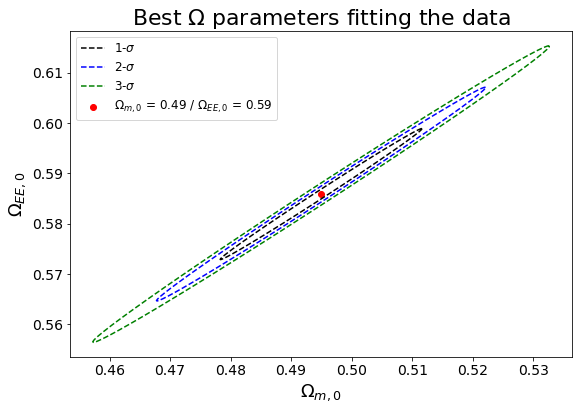

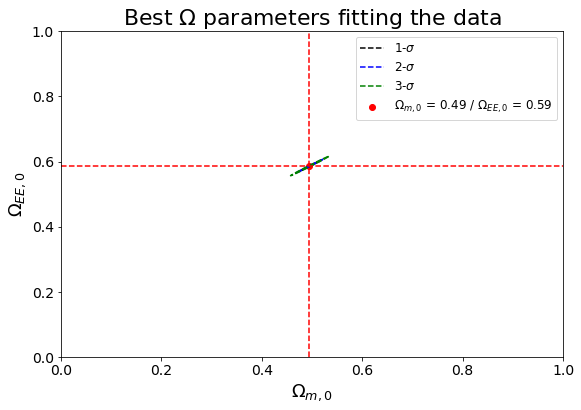

In [ ]:
# Monto as equações paramétricas da elipse rotacionada/transladada no espaço Omega_m0 x Omega_EE0

def Omega_m0_elipse(t, a, b):
  return Omega_m0_best_fit+(a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta))

def Omega_EE0_elipse(t, a, b):
  return Omega_EE0_best_fit+(a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta))

t_plot = np.arange(0, 2*np.pi+0.1, 0.1)

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + '$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit)
ax = plt.scatter(Omega_m0_best_fit, Omega_EE0_best_fit, color='red', label=legenda)
# Ponto (Omega_m0_best_fit, Omega_EE0_best_fit)

# Defino os parâmetros da elipse para cada intervalo de confiança

alpha = [1.52, 2.48, 3.44] # vetor de fatores multiplicativos alpha
# O elemento 0 representa o alpha associado à elipse 1-sigma
# O elemento 1 representa o alpha associado à elipse 2-sigma
# O elemento 2 representa o alpha associado à elipse 3-sigma

a_1s = a_0*alpha[0]
b_1s = b_0*alpha[0]

a_2s = a_0*alpha[1]
b_2s = b_0*alpha[1]

a_3s = a_0*alpha[2]
b_3s = b_0*alpha[2]

# Faço os plots
# 1-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ parameters fitting the data', fontsize=22)
plt.xlabel('$\Omega_{m,0}$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.49,0.52)
#plt.ylim(0.58,0.62)
plt.legend(fontsize=12)
plt.show()
print()

# _____________________________________________________________________________________

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + '$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit)
ax = plt.scatter(Omega_m0_best_fit, Omega_EE0_best_fit, color='red', label=legenda)

# Faço os plots
# 1-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ parameters fitting the data', fontsize=22)
plt.xlabel('$\Omega_{m,0}$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.50,0.51)
#plt.ylim(0.59,0.61)
plt.xlim(0,1)
plt.ylim(0,1)

# Plot de linhas horizontais e verticais para facilitar a visualização do ponto
ax = plt.axhline(y=Omega_EE0_best_fit, color='red', linestyle='dashed')
ax = plt.axvline(x=Omega_m0_best_fit, color='red', linestyle='dashed')

plt.legend(fontsize=12)
plt.show()

### Tarefa (c)

Calcule o melhor valor (máxima verossimilhança) e as os intervalos de 68,3%, 95,4 % e 99,7% (1,2,3 “$σ$” de uma distribuição Normal) para $Ω_m$ e $Ω_{EE}$ , supondo $w=-1$ e com um prior na curvatura vinda da CMB: $Ω_K = -0,06±0,05$. Para isso simplesmente  adicione ao valor do 𝜒2 um termo $[(1- Ω_m - Ω_{EE}) + 0,06]^2/0,05^2]$ e proceda como no caso anterior.

- Ou seja, aqui basta acrescentarmos o termo acima ao "chi2" (função Q) calculado para cada modelo de universo e, novamente, verificar quais são os parâmetros de ajuste que melhor ajustam os dados considerando esse "prior"

In [ ]:
# Para fazer esse cálculo, utilizo a função "ajusta_dados" com algumas pequenas modificações
# no loop do cálculo de chi2 (i.e., do cálculo de Q)

# Construo uma função para ajustar os valores de Omega_m0 e Omega_EE0 que melhor se encaixam
# aos dados observados supondo w = -1 (energia escura do tipo const cosmológica)

# Parâmetros de entrada:
  # - z: Vetor com os valores observados de redshift
  # - mu: Vetor com os valores medidos de módulo de distância
  # - erro_mu: Vetor com os valores de erro (incerteza) dos módulos de distância medidos
  # - start_omegas: valor inicial de Omega_m0 e Omega_EE0
  # - end_omegas: valor final de Omega_m0 e Omega_EE0
  # - N: quantidade de pontos desejados dentro do intervalo [start_omegas, end_omegas]
  # - w: parâmetro da equação de estado associado à energia escura
  # - param_curv: parâmetro indicativo de curvatura
  # - Omega_k0: valor do parâmetro de curvatura (legítimo) obtido como prior
  # - sigma_Omega_k0: incerteza (estimativa do erro) associada ao prior Omega_k0

# Obs.: param_curv é uma variável auxiliar que utilizaremos; deverá receber valor 0 
# se o modelo de universo em utilização apresentar curvatura plana e valor -1
# se a curvatura do universo em estudo for desconhecida (caso genérico)

# Valores de saída:
  # - Omega_m0_best_fit: valor de Omega_m0 que melhor se ajusta aos dados (considerando o modelo de universo)
  # - Omega_EE0_best_fit: valor de Omega_EE0 que melhor se ajusta aos dados (considerando o modelo de universo)
  # - chi2_min: valor da soma quadrática dos resíduos para Omega_m0_best_fit e Omega_EE0_best_fit
  # - chi2: matriz de resíduos quadráticos associada aos parâmetros "omega" utilizados (i.e., matriz de "chi2's")
  # - cov: matriz de covariância do ajuste

def ajusta_dados_considera_prior(z, mu, erro_mu, start_omegas, end_omegas, N, w, param_curv, Omega_k0, sigma_Omega_k0):
  import numpy as np 

  # Quantidades auxiliares
  zsize = len(z)
  H0 = 70 # km s^-1 Mpc^-1

  # __________________________________________________________________
  # 1) Construção dos parâmetros Omega_m0 e Omega_EE0
  if param_curv == 0: # Caso do universo de curvatura plana (Omega_m e Omega_EE conectados)
    Omega_m0 = np.linspace(start_omegas, end_omegas, N)
    Omega_EE0 = 1 - Omega_m0

  else: # Caso genérico de universo com curvatura desconhecida
    Omega_m0 = np.linspace(start_omegas, end_omegas, N)
    Omega_EE0 = np.linspace(start_omegas, end_omegas, N)
  
  # Quantidades auxiliares
  Om_size = len(Omega_m0)
  OEE_size = len(Omega_EE0)

  # __________________________________________________________________
  # 2) Construção da grade de parâmetros (Omega_m0 x Omega_EE0)

  M = [] # Matriz da grade de parâmetros

  # Cada elemento da matriz M representa um vetor com um par de parâmetros, ou seja
  # M[i][j] == [ Omega_m0[i], Omega_EE0[j] ]
  
  for i in range(Om_size):
    auxiliar1 = [] # Vetor que compõe a linha (i) de M

    for j in range(OEE_size): 
      auxiliar2 = [Omega_m0[i], Omega_EE0[j]] # Vetor auxiliar que compõe a coluna (j) de M
      auxiliar1.append(auxiliar2)

    M.append(auxiliar1) # Coloco a linha i dentro da matriz

  M = np.array(M) # Grade de parâmetros finalizada

  # __________________________________________________________________
  # 3) Calculo a matriz de Q, o chi2 e os melhores parâmetros do ajuste

  chi2= np.zeros( (Om_size, OEE_size) )
  chi2_min = 100000 # defino o chi2 inicialmente com um valor absurdo só pra dar início ao loop corretamente
  Omega_m0_best_fit = 0
  Omega_EE0_best_fit = 0

  for i in range(Om_size):
    for j in range(OEE_size):
      # Aqui dentro eu tenho acesso ao vetor [Omega_m0[i], Omega_EE0[j]] de M
      
      Omega_m0i = M[i][j][0]
      Omega_EE0j = M[i][j][1]

      # Faço um novo loop para construir a matriz Q de resíduos e obter
      # as quantiades desejadas

      soma = 0 # variável auxiliar para calcular a soma dos resíduos quadráticos
      prior = ( (1 - Omega_m0i - Omega_EE0j) - Omega_k0 )**2 / sigma_Omega_k0**2   # prior do ajuste (considerando dados da CMB)

      for k in range(zsize):
        mod_dist, erro_mod_dist = mu_numerico(H0, Omega_m0i, Omega_EE0j, w, z[k])
        soma += ( ( mu[k] - mod_dist )/erro_mu[k] )**2 + prior

      # Atualizo a matriz chi2 e verifico as condições de ajuste
      chi2[i][j] = soma

      if param_curv == 0: # se eu estiver num modelo de curvatura plana
        if soma < chi2_min and i==j: # preciso verificar se a soma de resíduos é mínima *E* se eu estou na diagonal principal de M

        # (por que é na diagonal principal de M que estão armazenados os parâmetros associados ao modelo de universo plano)

          chi2_min = soma
          Omega_m0_best_fit = Omega_m0i
          Omega_EE0_best_fit = Omega_EE0j

          # Para facilitar o cálculo da matriz de Fisher, guardo os índices 
          # que forneceram os valores do ajuste
          i_min = i
          j_min = j

         
      else: # se eu estiver num modelo de curvatura genérica
        if soma < chi2_min: # preciso verificar somente se a soma de resíduos é mínima
          chi2_min = soma
          Omega_m0_best_fit = Omega_m0i
          Omega_EE0_best_fit = Omega_EE0j

          # Para facilitar o cálculo da matriz de Fisher, guardo os índices 
          # que forneceram os valores do ajuste
          i_min = i
          j_min = j

  # __________________________________________________________________
  # 4) Obtenção da matriz de Fisher

  # Defino uma quantidade auxiliar: delta_omega (igual para ambos os omegas, por construção dos vetores)
  delta_omega = np.abs(end_omegas - start_omegas)/N

  # Elemento 00 da matriz de Fisher (2 derivada de chi2_min em 'x' = Omega_m)
  F_00 = (1/2)*( chi2[i_min+1,j_min] - 2*chi2[i_min,j_min] + chi2[i_min-1,j_min] )*(1/delta_omega)**2

  # Elemento 11 da matriz de Fisher (2 derivada de chi2_min em 'y' = Omega_EE)
  F_11 = (1/2)*( chi2[i_min,j_min+1] - 2*chi2[i_min,j_min] + chi2[i_min,j_min-1] )*(1/delta_omega)**2

  # Elementos 01/10 da matriz de Fisher 
  F_12_21 = (1/2)*( chi2[i_min+1, j_min+1] - chi2[i_min-1, j_min+1] - chi2[i_min+1, j_min-1] + chi2[i_min-1, j_min-1] )*(1/(4*delta_omega**2))

  F = np.array([ 
    [F_00, F_12_21],
    [F_12_21, F_11]
  ])

  # __________________________________________________________________
  # 5) Obtenção da matriz de covariância
  # Uma vez calculada a matriz de Fisher, a matriz covariância é simplesmente a inversa

  cov = np.linalg.inv(F)

  return Omega_m0_best_fit, Omega_EE0_best_fit, chi2, chi2_min, cov

In [ ]:
# A expectativa é que a inclusão do prior na análise estatística altere os valores Omega_m0_best_fit e Omega_EE0_best_fit
Omega_k0 = -0.06 # adimensional
sigma_Omega_k0 = 0.05 # adimensional

Omega_m0_best_fit, Omega_EE0_best_fit, chi2, chi2_min, cov = \
ajusta_dados_considera_prior(z_i, mu_i, erro_mu_i, 0, 1, 100, -1, -1, Omega_k0, sigma_Omega_k0)

apresenta_resultados(Omega_m0_best_fit, Omega_EE0_best_fit, cov, chi2_min)

Parâmetros do ajuste obtidos pelo método da força bruta

Omega_m0 = 0.485
Omega_EE0 = 0.576
chi2 (Q mínimo)= 562.357

Matriz de covariância: 
[ 0.00025594 -0.00025408]
[-0.00025408  0.00025645]


In [ ]:
'{:.4f}'.format(np.sqrt(0.00025645))

'0.0160'

In [ ]:
# Apresentação da elipse de confiança
sigma_Omega_m0_best_fit = np.sqrt(cov[0][0])
sigma_Omega_EE0_best_fit = np.sqrt(cov[1][1])
sigma_misto = cov[0][1]

a_0 = (sigma_Omega_m0_best_fit**2 + sigma_Omega_EE0_best_fit**2)/2 \
+ np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)**2 + sigma_misto**2)

b_0 = (sigma_Omega_m0_best_fit**2 + sigma_Omega_EE0_best_fit**2)/2 \
- np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)**2 + sigma_misto**2)

#theta = (1/2)*np.arctan( (2*sigma_misto)/(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2) )
theta = (1/2)*np.arctan( (2*sigma_misto)/np.abs((sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2)) )

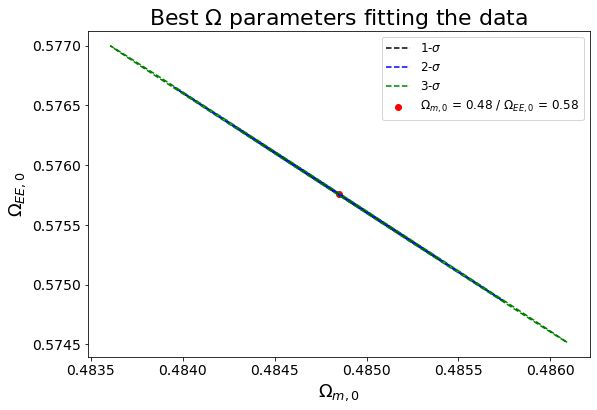

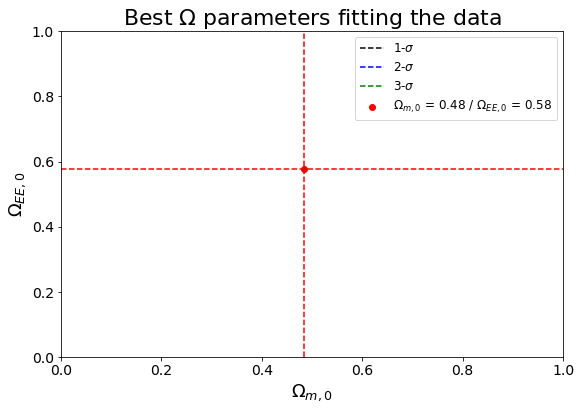

In [ ]:
# Monto as equações paramétricas da elipse rotacionada/transladada no espaço Omega_m0 x Omega_EE0

def Omega_m0_elipse(t, a, b):
  return Omega_m0_best_fit+(a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta))

def Omega_EE0_elipse(t, a, b):
  return Omega_EE0_best_fit+(a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta))

t_plot = np.arange(0, 2*np.pi+0.1, 0.1)

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + '$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit)
ax = plt.scatter(Omega_m0_best_fit, Omega_EE0_best_fit, color='red', label=legenda)
# Ponto (Omega_m0_best_fit, Omega_EE0_best_fit)

# Defino os parâmetros da elipse para cada intervalo de confiança

alpha = [1.52, 2.48, 3.44] # vetor de fatores multiplicativos alpha
# O elemento 0 representa o alpha associado à elipse 1-sigma
# O elemento 1 representa o alpha associado à elipse 2-sigma
# O elemento 2 representa o alpha associado à elipse 3-sigma

a_1s = a_0*alpha[0]
b_1s = b_0*alpha[0]

a_2s = a_0*alpha[1]
b_2s = b_0*alpha[1]

a_3s = a_0*alpha[2]
b_3s = b_0*alpha[2]

# Faço os plots
# 1-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ parameters fitting the data', fontsize=22)
plt.xlabel('$\Omega_{m,0}$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.49,0.52)
#plt.ylim(0.58,0.62)
plt.legend(fontsize=12)
plt.show()
print()

# _____________________________________________________________________________________

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + '$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit)
ax = plt.scatter(Omega_m0_best_fit, Omega_EE0_best_fit, color='red', label=legenda)

# Faço os plots
# 1-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(Omega_m0_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ parameters fitting the data', fontsize=22)
plt.xlabel('$\Omega_{m,0}$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.50,0.51)
#plt.ylim(0.59,0.61)
plt.xlim(0,1)
plt.ylim(0,1)

# Plot de linhas horizontais e verticais para facilitar a visualização do ponto
ax = plt.axhline(y=Omega_EE0_best_fit, color='red', linestyle='dashed')
ax = plt.axvline(x=Omega_m0_best_fit, color='red', linestyle='dashed')

plt.legend(fontsize=12)
plt.show()

### Tarefa (d)

Calcule o melhor valor (máxima verossimilhança) e as os intervalos de 68,3%, 95,4 % e 99,7% (1, 2, 3 “σ” de uma distribuição Normal) para $Ω_m$ e $w$ , supondo um Universo plano. 

In [ ]:
# Para fazer esse cáculo, utilizo a função "ajusta_dados" com algumas modificações no código
# de modo a obter os parâmetros Omega_m0 e w, ao invés de Omega_m0 e Omega_EE0

# Construo uma função para ajustar os valores de Omega_m0 (e Omega_EE0, conseq) e w que melhor se encaixam
# aos dados observados supondo um modelo de universo plano

# Parâmetros de entrada:
  # - z: Vetor com os valores observados de redshift
  # - mu: Vetor com os valores medidos de módulo de distância
  # - erro_mu: Vetor com os valores de erro (incerteza) dos módulos de distância medidos
  # - start_omegas: valor inicial de Omega_m0 e Omega_EE0
  # - end_omegas: valor final de Omega_m0 e Omega_EE0
  # - start_w: valor inicial de w
  # - end_w: valor final de w
  # - N: quantidade de pontos desejados dentro do intervalo [start_omegas, end_omegas] // e do intervalo [start_w, end_w]


# Valores de saída:
  # - Omega_m0_best_fit: valor de Omega_m0 que melhor se ajusta aos dados (considerando o modelo de universo plano)
  # - Omega_EE0_best_fit: valor de Omega_EE0 que melhor se ajusta aos dados (considerando o modelo de universo plano)
  # - w_best_fit: valor do parâmetro da eq. de estado que melhor se ajusta aos dados
  # - chi2_min: valor da soma quadrática dos resíduos para Omega_m0_best_fit e Omega_EE0_best_fit
  # - chi2: matriz de resíduos quadráticos associada aos parâmetros "Omega" e "w" utilizados (i.e., matriz de "chi2's")
  # - cov: matriz de covariância do ajuste (nesse caso, associada aos parâmetros Omega_m0 e w)

  # Ps.: como estamos tratando um universo de curvatura plana, Omega_m0 e Omega_EE0 estão conectados linearmente
  # por Omega_EE0 = 1 - Omega_m0. Portanto, a matriz de covariância associada aos parâmetros Omega_EE0 e w são as mesmas.
  # (i.e., sigma_Omega_EE0 = sigma_Omega_m0)

def ajusta_dados_considera_eq_de_estado(z, mu, erro_mu, start_omegas, end_omegas, start_w, end_w, N):
  import numpy as np 

  # Quantidades auxiliares
  zsize = len(z)
  H0 = 70 # km s^-1 Mpc^-1

  # __________________________________________________________________
  # 0) Construção do parâmetro w
  w = np.linspace(start_w, end_w, N)

  # __________________________________________________________________
  # 1) Construção dos parâmetros Omega_m0 e Omega_EE0
  # Como estou no modelo de universo de curvatura plana (Omega_m e Omega_EE conectados)
  Omega_m0 = np.linspace(start_omegas, end_omegas, N)
  Omega_EE0 = 1 - Omega_m0
  
  # Quantidades auxiliares
  Om_size = len(Omega_m0)
  OEE_size = len(Omega_EE0)
  w_size = len(w)

  # __________________________________________________________________
  # 2) Construção da grade de parâmetros (Omega_m0 x Omega_EE0)

  M = [] # Matriz da grade de parâmetros

  # Cada elemento da matriz M representa um vetor com um par de parâmetros, ou seja
  # M[i][j] == [ Omega_m0[i], w[j] ]
  
  for i in range(Om_size):
    auxiliar1 = [] # Vetor que compõe a linha (i) de M

    for j in range(OEE_size): 
      auxiliar2 = [Omega_m0[i], w[j]] # Vetor auxiliar que compõe a coluna (j) de M
      auxiliar1.append(auxiliar2)

    M.append(auxiliar1) # Coloco a linha i dentro da matriz

  M = np.array(M) # Grade de parâmetros finalizada

  # __________________________________________________________________
  # 3) Calculo a matriz de Q, o chi2 e os melhores parâmetros do ajuste

  chi2= np.zeros( (Om_size, w_size) )
  chi2_min = 100000 # defino o chi2 inicialmente com um valor absurdo só pra dar início ao loop corretamente
  Omega_m0_best_fit = 0
  w_best_fit = 0

  for i in range(Om_size):
    for j in range(w_size):
      # Aqui dentro eu tenho acesso ao vetor [Omega_m0[i], w[j]] de M
      
      Omega_m0i = M[i][j][0]
      wj = M[i][j][1]
      # Como estou tratando um universo plano, Omega_EE0j = 1 - Omega_m0i 

      # Faço um novo loop para construir a matriz Q de resíduos e obter
      # as quantiades desejadas

      soma = 0 # variável auxiliar para calcular a soma dos resíduos quadráticos
      for k in range(zsize):
        mod_dist, erro_mod_dist = mu_numerico(H0, Omega_m0i, 1-Omega_m0i, wj, z[k])
        soma += ( ( mu[k] - mod_dist )/erro_mu[k] )**2

      # Atualizo a matriz chi2 e verifico as condições de ajuste
      chi2[i][j] = soma
         
      # se eu estiver num modelo de curvatura genérica
      if soma < chi2_min: # preciso verificar somente se a soma de resíduos é mínima
        chi2_min = soma
        Omega_m0_best_fit = Omega_m0i
        Omega_EE0_best_fit = 1-Omega_m0_best_fit
        w_best_fit = wj

        # Para facilitar o cálculo da matriz de Fisher, guardo os índices 
        # que forneceram os valores do ajuste
        i_min = i
        j_min = j

  # __________________________________________________________________
  # 4) Obtenção da matriz de Fisher

  # Defino uma quantidade auxiliar: delta_omega (igual para ambos os omegas, por construção dos vetores)
  delta_omega = np.abs(end_omegas - start_omegas)/N

  # Elemento 00 da matriz de Fisher (2 derivada de chi2_min em 'x' = Omega_m)
  F_00 = (1/2)*( chi2[i_min+1,j_min] - 2*chi2[i_min,j_min] + chi2[i_min-1,j_min] )*(1/delta_omega)**2

  # Elemento 11 da matriz de Fisher (2 derivada de chi2_min em 'y' = Omega_EE)
  F_11 = (1/2)*( chi2[i_min,j_min+1] - 2*chi2[i_min,j_min] + chi2[i_min,j_min-1] )*(1/delta_omega)**2

  # Elementos 01/10 da matriz de Fisher 
  F_12_21 = (1/2)*( chi2[i_min+1, j_min+1] - chi2[i_min-1, j_min+1] - chi2[i_min+1, j_min-1] + chi2[i_min-1, j_min-1] )*(1/(4*delta_omega**2))

  F = np.array([ 
    [F_00, F_12_21],
    [F_12_21, F_11]
  ])

  # __________________________________________________________________
  # 5) Obtenção da matriz de covariância
  # Uma vez calculada a matriz de Fisher, a matriz covariância é simplesmente a inversa

  cov = np.linalg.inv(F)

  return Omega_m0_best_fit, Omega_EE0_best_fit, w_best_fit, chi2, chi2_min, cov

In [ ]:
Omega_m0_best_fit, Omega_EE0_best_fit, w_best_fit, chi2, chi2_min, cov = \
ajusta_dados_considera_eq_de_estado(z_i, mu_i, erro_mu_i, 0, 1, -2, 2, 100)

print('Parâmetro da equação de estado: w = {:.3f}'.format(w_best_fit))
apresenta_resultados(Omega_m0_best_fit, Omega_EE0_best_fit, cov, chi2_min)

Parâmetro da equação de estado: w = -1.152
Parâmetros do ajuste obtidos pelo método da força bruta

Omega_m0 = 0.505
Omega_EE0 = 0.495
chi2 (Q mínimo)= 562.278

Matriz de covariância: 
[ 0.00355954 -0.00327795]
[-0.00327795  0.00321675]


Para aplicar os cálculos da matriz de confiança, precisamos encontrar o sigma_misto associado aos parâmetros Omega_m0 e Omega_EE0. Dada a relação entre essas duas variáveis, temos que a correlação entre esses dois parâmetros é NEGATIVA. O quão negativa é não dá pra saber...

- Dado que conhecemos as incs de Omega_m0, Omega_EE0 e w, e as correlações entre os omegas e o parâmetro w, podemos fazer plots de Omega_m0 x w e Omega_EE0 x w, mas Omega_m0 x Omega_EE0 não tem como.

In [ ]:
'{:.4f}'.format(np.sqrt(0.0032167))

'0.0567'

In [ ]:
# Apresentação da elipse de confiança
sigma_Omega_m0_best_fit = np.sqrt(cov[0][0])
#sigma_Omega_EE0_best_fit = np.sqrt(cov[0][0]) # Omega_m0 e Omega_EE0 têm a mesma inc (relação linear)
sigma_w = np.sqrt(cov[1][1])
sigma_misto = cov[0][1] # sigma_misto entre Omega_m0 e w

a_0 = (sigma_Omega_m0_best_fit**2 + sigma_w**2)/2 \
+ np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_w**2)**2 + sigma_misto**2)

b_0 = (sigma_Omega_m0_best_fit**2 + sigma_w**2)/2 \
- np.sqrt((1/4)*(sigma_Omega_m0_best_fit**2 - sigma_w**2)**2 + sigma_misto**2)

#theta = (1/2)*np.arctan( (2*sigma_misto)/(sigma_Omega_m0_best_fit**2 - sigma_Omega_EE0_best_fit**2) )
theta = (1/2)*np.arctan( (2*sigma_misto)/np.abs((sigma_Omega_m0_best_fit**2 - sigma_w**2)) )

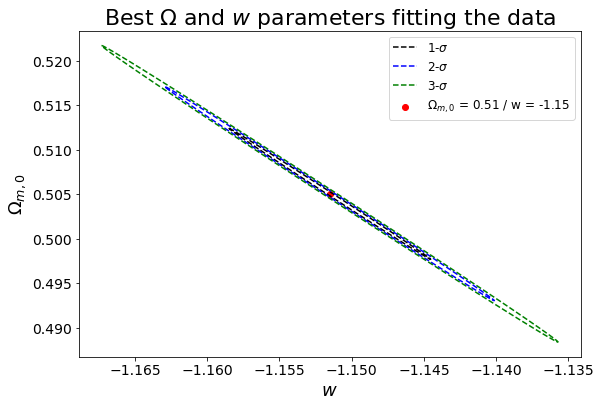

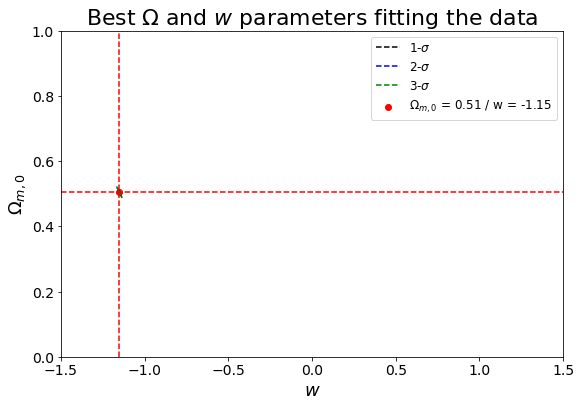

In [ ]:
# Monto as equações paramétricas da elipse rotacionada/transladada no espaço Omega_m0 x Omega_EE0

def Omega_m0_elipse(t, a, b):
  return Omega_m0_best_fit+(a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta))

def w_elipse(t, a, b):
  return w_best_fit+(a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta))

t_plot = np.arange(0, 2*np.pi+0.1, 0.1)

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + 'w = {:.2f}'.format(w_best_fit)
 
ax = plt.scatter(w_best_fit, Omega_m0_best_fit, color='red', label=legenda)
# Ponto (w_best_fit, Omega_m0_best_fit)

# Defino os parâmetros da elipse para cada intervalo de confiança

alpha = [1.52, 2.48, 3.44] # vetor de fatores multiplicativos alpha
# O elemento 0 representa o alpha associado à elipse 1-sigma
# O elemento 1 representa o alpha associado à elipse 2-sigma
# O elemento 2 representa o alpha associado à elipse 3-sigma

a_1s = a_0*alpha[0]
b_1s = b_0*alpha[0]

a_2s = a_0*alpha[1]
b_2s = b_0*alpha[1]

a_3s = a_0*alpha[2]
b_3s = b_0*alpha[2]

# Faço os plots
# 1-sigma
ax = plt.plot(w_elipse(t_plot, a_1s, b_1s), Omega_m0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(w_elipse(t_plot, a_2s, b_2s), Omega_m0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(w_elipse(t_plot, a_3s, b_3s), Omega_m0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ and $w$ parameters fitting the data', fontsize=22)
plt.xlabel('$w$', fontsize=18)
plt.ylabel('$\Omega_{m,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.49,0.52)
#plt.ylim(0.58,0.62)
plt.legend(fontsize=12)
plt.show()
print()

# _____________________________________________________________________________________

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{m,0}$ = ' + '{:.2f}'.format(Omega_m0_best_fit) + ' / ' + 'w = {:.2f}'.format(w_best_fit)
ax = plt.scatter(w_best_fit, Omega_m0_best_fit, color='red', label=legenda)

# Faço os plots
# 1-sigma
ax = plt.plot(w_elipse(t_plot, a_1s, b_1s), Omega_m0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(w_elipse(t_plot, a_2s, b_2s), Omega_m0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(w_elipse(t_plot, a_3s, b_3s), Omega_m0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ and $w$ parameters fitting the data', fontsize=22)
plt.xlabel('$w$', fontsize=18)
plt.ylabel('$\Omega_{m,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.50,0.51)
#plt.ylim(0.59,0.61)
plt.xlim(-1.5,1.5)
plt.ylim(0,1)

# Plot de linhas horizontais e verticais para facilitar a visualização do ponto
ax = plt.axhline(y=Omega_m0_best_fit, color='red', linestyle='dashed')
ax = plt.axvline(x=w_best_fit, color='red', linestyle='dashed')

plt.legend(fontsize=12)
plt.show()

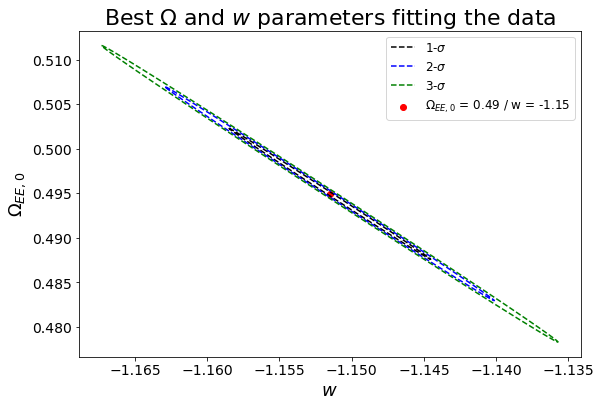

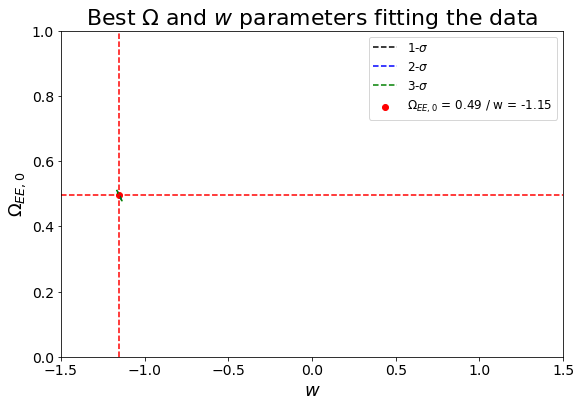

In [ ]:
# Monto as equações paramétricas da elipse rotacionada/transladada no espaço Omega_m0 x Omega_EE0

def Omega_EE0_elipse(t, a, b):
  return Omega_EE0_best_fit+(a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta))

def w_elipse(t, a, b):
  return w_best_fit+(a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta))

t_plot = np.arange(0, 2*np.pi+0.1, 0.1)

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit) + ' / ' + 'w = {:.2f}'.format(w_best_fit)
ax = plt.scatter(w_best_fit, Omega_EE0_best_fit, color='red', label=legenda)
# Ponto (w_best_fit, Omega_m0_best_fit)

# Defino os parâmetros da elipse para cada intervalo de confiança

alpha = [1.52, 2.48, 3.44] # vetor de fatores multiplicativos alpha
# O elemento 0 representa o alpha associado à elipse 1-sigma
# O elemento 1 representa o alpha associado à elipse 2-sigma
# O elemento 2 representa o alpha associado à elipse 3-sigma

a_1s = a_0*alpha[0]
b_1s = b_0*alpha[0]

a_2s = a_0*alpha[1]
b_2s = b_0*alpha[1]

a_3s = a_0*alpha[2]
b_3s = b_0*alpha[2]

# Faço os plots
# 1-sigma
ax = plt.plot(w_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(w_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(w_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ and $w$ parameters fitting the data', fontsize=22)
plt.xlabel('$w$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.49,0.52)
#plt.ylim(0.58,0.62)
plt.legend(fontsize=12)
plt.show()
print()

# _____________________________________________________________________________________

ax = plt.figure(figsize=(9,6))
legenda='$\Omega_{EE,0}$ = ' + '{:.2f}'.format(Omega_EE0_best_fit) + ' / ' + 'w = {:.2f}'.format(w_best_fit)
ax = plt.scatter(w_best_fit, Omega_EE0_best_fit, color='red', label=legenda)

# Faço os plots
# 1-sigma
ax = plt.plot(w_elipse(t_plot, a_1s, b_1s), Omega_EE0_elipse(t_plot, a_1s, b_1s), color='black', linestyle='dashed', label='1-$\sigma$')

# 2-sigma
ax = plt.plot(w_elipse(t_plot, a_2s, b_2s), Omega_EE0_elipse(t_plot, a_2s, b_2s), color='blue', linestyle='dashed', label='2-$\sigma$')

# 3-sigma
ax = plt.plot(w_elipse(t_plot, a_3s, b_3s), Omega_EE0_elipse(t_plot, a_3s, b_3s), color='green', linestyle='dashed', label='3-$\sigma$')

plt.title('Best $\Omega$ and $w$ parameters fitting the data', fontsize=22)
plt.xlabel('$w$', fontsize=18)
plt.ylabel('$\Omega_{EE,0}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0.50,0.51)
#plt.ylim(0.59,0.61)
plt.xlim(-1.5,1.5)
plt.ylim(0,1)

# Plot de linhas horizontais e verticais para facilitar a visualização do ponto
ax = plt.axhline(y=Omega_EE0_best_fit, color='red', linestyle='dashed')
ax = plt.axvline(x=w_best_fit, color='red', linestyle='dashed')

plt.legend(fontsize=12)
plt.show()